# Exercise 2: Interactive Segmentation

**Covered Topics: Lecture 5**

Your tic-tac-toe championship was a major success and everyone is waiting for the next event from you.
Meanwhile, some curious eyes have also noticed the impressive compression algorithm you developed.
Among them is a group of budding entrepreneurs who are working on a noble mission: to empower everyone to make their own *Cat Memes*.
Specifically, they are developing an app where you can take a photo of your cute cat, segment it out, and paste it on any background to design your own meme.
Crucially, the users only have to create a few scribbles, which mark the foreground (the cat) and background of the image.
As none of the founders are Computer Vision engineers, they have approached you to develop the segmentation algorithm for the app.
An overview of the desired pipeline is shown below.

</br>
</br>

![](https://drive.google.com/uc?export=view&id=1AyQIlnBRmQjbHquCQVDYdCO4m9UCLDqX)

</br>
</br>

**Details about the setup**
* For each test sample, the algorithm is provided a triplet consisting of the RGB image, the foreground (FG) scribble and the background (BG) scribble.
We denote this triplet as a *sample*.
* FG scribble is a grayscale image, where white pixels (255) are guaranteed to belong to the foreground (cat).
* BG scribble is a grayscale image, where white pixels (255) are guaranteed to belong to the background.
* The RGB image is a discrete image of 3 channels. Each pixel in these images is an integer which can take values between [0, 255]
* All images of a sample have the same size. However, note that RGB images from two different samples may have different sizes.

Given an input sample, your algorithm should output a single channel segmentation mask, of the same height and width as the input images.
The output should be a boolean NumPy array (dtype `bool`) with values `True` for the foreground (cat) and value `False` for the background regions.
In order to design your segmentation algorithm, we provide a validation dataset of 10 samples including ground truth segmentations.
</br>


**Evaluation Criteria**

Your algorithm will be evaluated using the Intersection-over-Union (IoU) metric.
Given the ground truth mask $A$ and the predicted mask $B$ for a sample, the metric computes

$$
\text{IoU} = \frac{A \cap B}{A \cup B}
$$

The exact details can be found in the function `compute_iou()` inside `utils.py`
The final EvaluationScore is obtained as the mean IoU over all test samples.
</br>

If you follow the suggested approach, the final algorithm will be stochastic.
To avoid fluctuation and a possibly lower score on the test set, than the baseline - be sure to use the same random seed.


**Passing requirement**

Your algorithm will be evaluated using an online evaluation server on a hidden test set.
In order to pass the exercise, you need to obtain an EvaluationScore of **greater than $0.56$** on the test set.
Additionally, your segmentation algorithm should be reasonably fast, that is, segment each sample in less than 5 seconds.
This is because the evaluation server will time out if your algorithm is too slow.
The ranking on the leaderboard is obtained using only the EvaluationScore.

Follow the steps in the rest of the notebook to generate the submission.
The evaluation server for the exercise is at https://codalab.lisn.upsaclay.fr/competitions/8068.

In [1]:
# These two lines ensure that we always import the latest version of a package, in case it has been modified.
%load_ext autoreload
%autoreload 2

import sys
import shutil
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Install PyMaxFlow. This library can optionally be used for advanced methods
!pip install PyMaxflow

%matplotlib inline

In [2]:
# Mount your drive and set the correct path
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**TODO:** Set the path in Google drive where you uploaded the handout, e.g. MyDrive/iacv/ex2 </br>
**NOTE:** Even if your drive is set to a different language - always start the path with MyDrive

In [2]:
# TODO
iacv_path = 'handout/'

env_path = Path("/home/simon/Downloads/ex2_interactive_segmentation/") / iacv_path
data_path = env_path / 'data'

# Add the handout folder to python paths
if str(env_path) not in sys.path:
    sys.path.append(str(env_path))

# Now we can import our other files
from utils import (
    compute_iou,
    evaluate_segmentation,
    load_sample,
    show_sample
)

from image_segmenter import ImageSegmenter

## Visualise random sample

In [3]:
# Go through 'val' folder and get names of subdirectories - one subdir is one sample
sample_dirs = [dd for dd in data_path.iterdir() if dd.is_dir()]

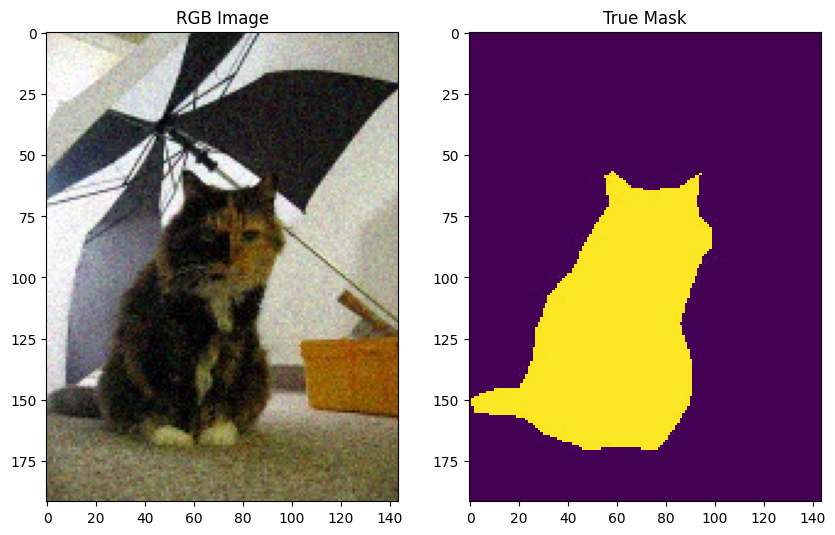

In [4]:
sample_path = data_path / '04'
sample_dd = load_sample(sample_path)
show_sample(sample_dd)

## Implement your solution

You are provided with a simple implementation of the `ImageSegmenter` class (`image_segmenter.py`).
The `ImageSegmenter` class is responsible to generate a segmentation mask, given a sample.
Modify this class to include your algorithm.

The rest of the exercise will roughly explain how the baseline solution was implemented.
If you follow the descriptions, implement the missing bits and tune some hyperparameters you will have no problem passing this exercise.

**Notes:**

* Having said that, you are free to implement whichever algorithm you fancy - as long as you do not use external packages and beat the baseline, anything is allowed.
* You are not allowed to use any external packages except the ones already imported in `image_segmenter.py`. Otherwise your submission will crash on the Evaluation server.
* You might want to first check out how the `ImageSegmenter` class will be used, before implementing.
Have a look at the code below

### K-means clustering

The FG/BG scribble masks provide us with locations in the image, which correspond to foreground/background respectively.
We can use these masks to perform segmentation as follows:
1. In a first step we extract all pixels intensities of foreground only.
We can then use a clustering algorithm, such as k-means, to create $k_1$ visual words, which "summarise" these foreground pixels.
2. The same can be done for background pixels using $k_2$ clusters.
3. With k-means we have now extracted two sets of cluster centroids: The first $k_1$ centroids represent a model of foreground pixels, while the other $k_2$ centroids correspond to background pixels.
4. We can now predict the label of any other pixel in the image using nearest neighbor classification: If the closest of all $k_1 + k_2$ centroids came from the foreground clusters, the pixel is labeled foreground - otherwise background.

What you have to do:
* Implement the k-means clustering algorithm.
The file `kmeans.py` provides a starting point.
* Implement the method `segment_image_kmeans()` of the `ImageSegmenter` class. Here you have to apply the kmeans clustering to FB/BG pixels separately. Also here you have to implement the nearest neighbor classifier.

The following image shows a segmentation, that has been created with this approach.
Note how the prediction is noisy and dark parts of the background are often mistaken to be foreground.

</br>

![](https://drive.google.com/uc?export=view&id=15hG1Atv_En0A0df0QTRU3i1P4dqRcoP9)

data shape: (621, 7)
data shape: (1356, 7)


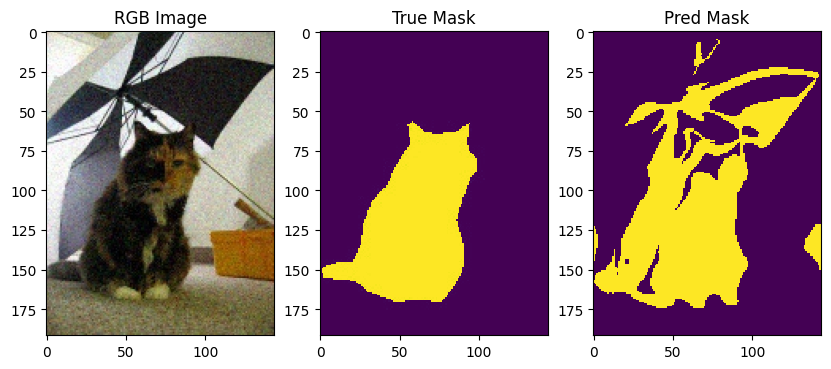

IoU score is: 0.570


In [89]:
# Run your segmentation algorithm
segmenter = ImageSegmenter(k_fg=6, k_bg=8, mode='kmeans')

mask_pred = segmenter.segment_image(sample_dd)

iou_score = compute_iou(
    sample_dd['mask_true'].astype(bool),
    mask_pred.astype(bool)
)

# Visualize your prediction
show_sample(sample_dd, mask_pred)
print(f'IoU score is: {iou_score:0.3f}')

### Extract patches (inside and outside of BB)

Until now, the prediction of a pixel's class was purely based on the intensity of said pixel alone.
It is probably beneficial to include the intensity values of neighboring pixels as well.

To this end, we now aim to extract all possible patches from the image.
That is for every pixel in the image we want to extract it's p x p neighborhood.
This neighborhood will later be used as feature for prediction.

A naive implementation of this patch extraction will be way to slow!
There is a way to do this rather efficiently with the help of NumPy's roll() function.
The below image shows the principle for a 1D array.

Can you adapt & implement this idea for the case of 2D images?

What you have to do:
* Implement the function `extract_patches()`. The file `extract_patches.py` provides a starting point.
There is also a quick test, to check the correct implementation of this patch extraction.
* Afterwards you can slightly adapt the `ImageSegmenter` to use the p x p neighborhood for prediciton.

</br>
</br>

![](https://drive.google.com/uc?export=view&id=1tYMIkxfDTQ7tYnbfo5C6wUtfOrxRwIiO)

</br>
</br>



In [41]:
from extract_patches import check_patch_extraction, extract_patches

check_patch_extraction(extract_patches)

Dummy image of shape 4 x 5 x 1
[[ 1  2  3  4  5]
 [ 6  7  8  9 10]
 [11 12 13 14 15]
 [16 17 18 19 20]]

Patch extraction failed at location [1, 1]. 
Expected:
 [[ 1.  2.  3.]
 [ 6.  7.  8.]
 [11. 12. 13.]] 
Received:
 [[7 7 7]
 [7 7 7]
 [7 7 7]]


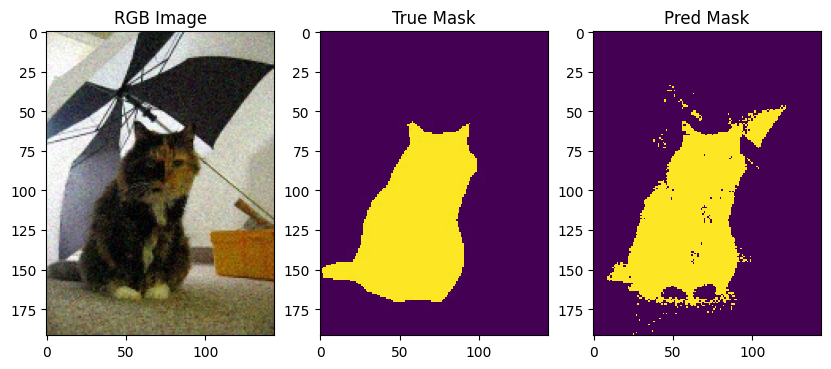

IoU score is: 0.768


In [144]:
# Run your segmentation algorithm
segmenter = ImageSegmenter(k_fg=6, k_bg=8, mode='kmeans')

mask_pred = segmenter.segment_image(sample_dd)

iou_score = compute_iou(
    sample_dd['mask_true'].astype(bool),
    mask_pred.astype(bool)
)

# Visualize your prediction
show_sample(sample_dd, mask_pred)
print(f'IoU score is: {iou_score:0.3f}')

### Evaluate on validation data

The performance of most algorithms has a strong dependence on hyper-parameters.
In the case of the baseline implementation, these are: the number of FG/BG cluster and the patch size to be used.

Can you find hyper-parameters that beat the baseline?

You may do it in a trial and error fashion. Alternatively you can do an exhaustive grid search, by looping of hyper-parameters - but that's up to you!

Good luck :-)

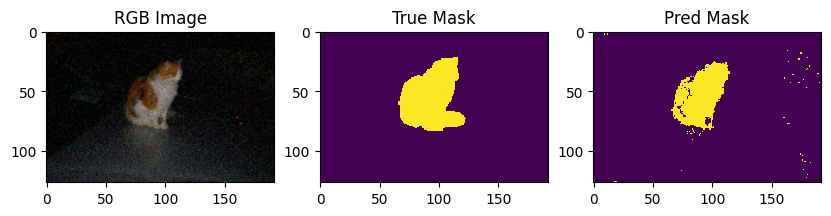

IoU score is: 0.576


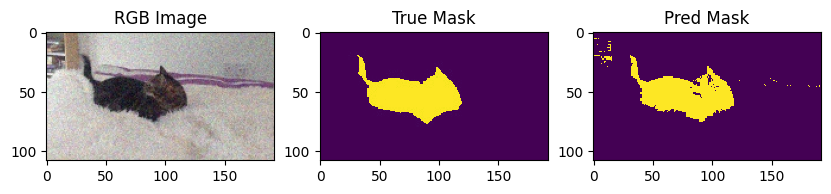

IoU score is: 0.754


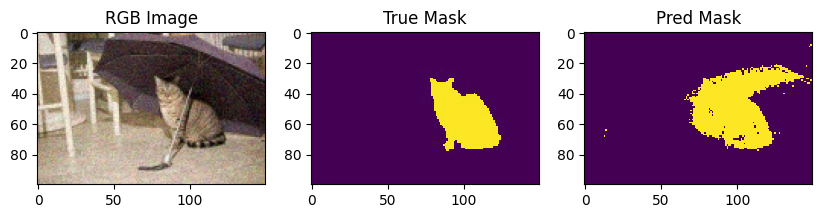

IoU score is: 0.541


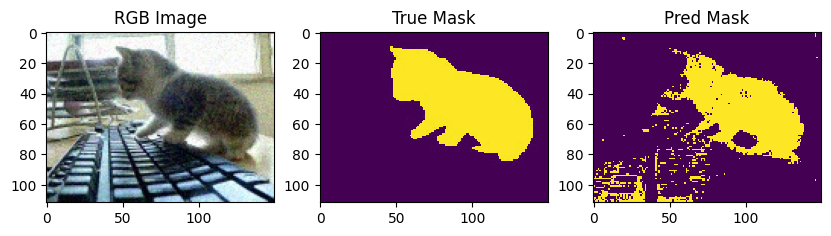

IoU score is: 0.578


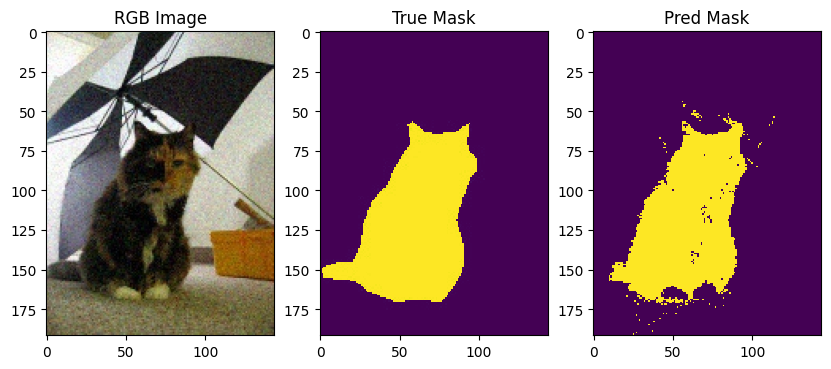

IoU score is: 0.803


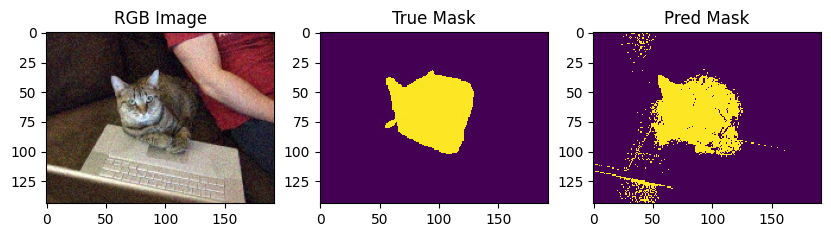

IoU score is: 0.641


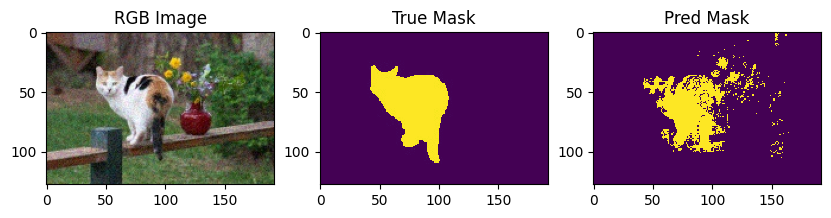

IoU score is: 0.530


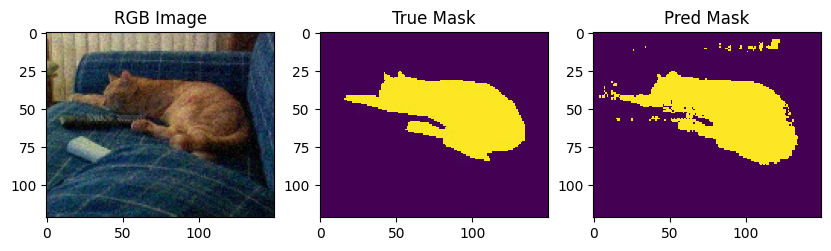

IoU score is: 0.795


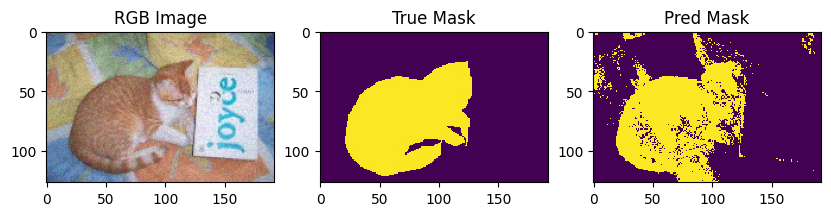

IoU score is: 0.708


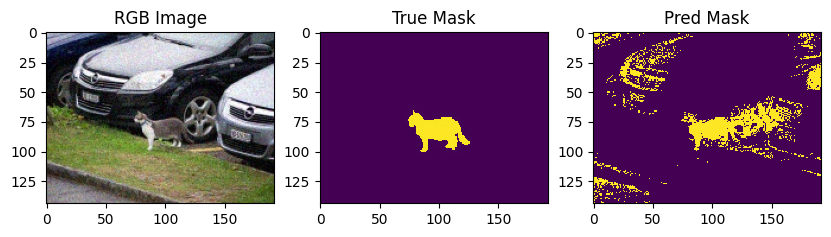

IoU score is: 0.205
Mean IoU: 0.613 with average time per image of 0.900 s


In [143]:
segmenter = ImageSegmenter(k_fg=4, k_bg=12, mode='kmeans')
iou, proc_time = evaluate_segmentation(segmenter, sample_dirs, display=True)

print(f"Mean IoU: {iou:0.3f} with average time per image of {proc_time:0.3f} s")

In [146]:
k_fg = range(7, 12)
k_bg = range(15, 20)
avg_mixes = [
	[40, 60, 70, 75, 80, 90, 100],
	[70, 75, 80, 90, 100]
	[],
]
best_iou = 0
best_setting = None
for fg in k_fg:
	for bg in k_bg:
		for avg_size in avg_mixes:
			segmenter = ImageSegmenter(k_fg=fg, k_bg=bg, mode='kmeans', avg_sizes=avg_size)
			iou, proc_time = evaluate_segmentation(segmenter, sample_dirs, display=False)
			if iou > best_iou:
				best_iou = iou
				best_setting = {"k_fg": fg, "k_bg": bg, "avg_sizes": avg_size}
				print(f"new best_iou: {best_iou}")
				print(f"new best_setting: {best_setting}")
print(f"best_iou: {best_iou}")
print(f"best_setting: {best_setting}")

new best_iou: 0.49295165670778485
new best_setting: {'k_fg': 2, 'k_bg': 2, 'avg_sizes': [40, 60, 70, 75, 80, 90, 100]}
new best_iou: 0.5291603721054453
new best_setting: {'k_fg': 2, 'k_bg': 3, 'avg_sizes': [40, 60, 70, 75, 80, 90, 100]}
new best_iou: 0.5737747438819605
new best_setting: {'k_fg': 2, 'k_bg': 4, 'avg_sizes': [40, 60, 70, 75, 80, 90, 100]}
new best_iou: 0.5740697522578393
new best_setting: {'k_fg': 2, 'k_bg': 5, 'avg_sizes': [40, 60, 70, 75, 80, 90, 100]}


KeyboardInterrupt: 

In [149]:
from multiprocessing import Pool

def eval(fg, bg, avg_size):
	segmenter = ImageSegmenter(k_fg=fg, k_bg=bg, mode='kmeans', avg_sizes=avg_size)
	iou, proc_time = evaluate_segmentation(segmenter, sample_dirs, display=False)
	return iou, fg, bg, avg_size

arguments = []
for fg in k_fg:
		for bg in k_bg:
			for avg_size in avg_mixes:
				arguments.append((fg, bg, avg_size))
print(arguments)
results = []
print("Starting pool")
with Pool(12) as p:
	results = p.starmap(eval, arguments)
print("finished pool")
print(results)

best_iou = 0
best_setting = None
print("starting selection")
for iou, fg, bg, avg_size in results:
	if iou > best_iou:
		best_iou = iou
		best_setting = {"k_fg": fg, "k_bg": bg, "avg_sizes": avg_size}
		print(f"new best_iou: {best_iou}")
		print(f"new best_setting: {best_setting}")
print(f"best_iou: {best_iou}")
print(f"best_setting: {best_setting}")
	

[(2, 2, [40, 60, 70, 75, 80, 90, 100]), (2, 2, [60, 75, 100]), (2, 2, [20, 75, 100]), (2, 2, [20, 40]), (2, 2, [90, 100]), (2, 2, [20]), (2, 2, [20, 80]), (2, 3, [40, 60, 70, 75, 80, 90, 100]), (2, 3, [60, 75, 100]), (2, 3, [20, 75, 100]), (2, 3, [20, 40]), (2, 3, [90, 100]), (2, 3, [20]), (2, 3, [20, 80]), (2, 4, [40, 60, 70, 75, 80, 90, 100]), (2, 4, [60, 75, 100]), (2, 4, [20, 75, 100]), (2, 4, [20, 40]), (2, 4, [90, 100]), (2, 4, [20]), (2, 4, [20, 80]), (2, 5, [40, 60, 70, 75, 80, 90, 100]), (2, 5, [60, 75, 100]), (2, 5, [20, 75, 100]), (2, 5, [20, 40]), (2, 5, [90, 100]), (2, 5, [20]), (2, 5, [20, 80]), (2, 6, [40, 60, 70, 75, 80, 90, 100]), (2, 6, [60, 75, 100]), (2, 6, [20, 75, 100]), (2, 6, [20, 40]), (2, 6, [90, 100]), (2, 6, [20]), (2, 6, [20, 80]), (2, 7, [40, 60, 70, 75, 80, 90, 100]), (2, 7, [60, 75, 100]), (2, 7, [20, 75, 100]), (2, 7, [20, 40]), (2, 7, [90, 100]), (2, 7, [20]), (2, 7, [20, 80]), (2, 8, [40, 60, 70, 75, 80, 90, 100]), (2, 8, [60, 75, 100]), (2, 8, [20, 7

## Create submission


After finishing your implementation, you can run the next cell to generate your submission.
We simply copy all relevant files to the submission folder.
Download the submission folder (**without renaming**) as a zip, and upload it to the evaluation server.

In [140]:
out_dir = env_path / 'submission'
out_dir.mkdir(exist_ok=True)

shutil.copyfile(str(env_path / 'kmeans.py'), str(out_dir / 'kmeans.py'))
shutil.copyfile(str(env_path / 'extract_patches.py'), str(out_dir / 'extract_patches.py'))
shutil.copyfile(str(env_path / 'advanced_methods.py'), str(out_dir / 'advanced_methods.py'))
shutil.copyfile(str(env_path / 'image_segmenter.py'), str(out_dir / 'image_segmenter.py'))

'/home/simon/Downloads/ex2_interactive_segmentation/handout/submission/image_segmenter.py'